In [26]:
import psycopg2
import numpy as np
import pandas as pd

In [28]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

In [29]:
import plotly.express as px
import plotly.graph_objs as go

In [30]:
from datetime import datetime, time

In [31]:
host="192.168.2.23"
port=5432
user="amt"
dbname="qdap_test"

In [33]:
def make_connection_to_db(host, port, user, dbname):
    conn = psycopg2.connect(host= host, port=port, user=user, dbname=dbname)
    cursor = conn.cursor()
    return cursor, conn

In [186]:
def fetch_options_data_timeframe(cursor, symbol, expiry_type, start_date, end_date):
    cursor.execute(
        f'''
            SELECT *
            FROM ohlcv_options_per_minute oopm
            WHERE symbol = '{symbol}' 
            AND oopm.expiry_type = '{expiry_type}'
            AND oopm.expiry <= '{end_date}'
            AND oopm.expiry >= '{start_date}'
            ORDER BY date_timestamp ASC;
        '''
    )
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [188]:
def fetch_options_data(cursor, symbol, expiry):
    cursor.execute(
        f'''
            SELECT *
            FROM ohlcv_options_per_minute oopm
            WHERE symbol = '{symbol}' 
            AND expiry_type = 'I'
            AND expiry = (
                SELECT MAX(oopmm.expiry)
                FROM ohlcv_options_per_minute oopmm
                WHERE oopmm.symbol = '{symbol}'
                AND oopmm.expiry_type = 'I'
                AND oopmm.expiry = '{expiry}'
            )
            ORDER BY date_timestamp ASC;
            
        '''
    )
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [190]:
def fetch_futures_data(cursor, symbol, x=0):
    query = f'''
        SELECT *
        FROM ohlcv_future_per_minute ofpm
        WHERE ofpm.symbol = '{symbol}'
        AND ofpm.expiry_type = 'I'
        AND ofpm.expiry = (
            SELECT ofpmm.expiry 
            FROM ohlcv_future_per_minute ofpmm
            WHERE ofpmm.symbol = '{symbol}'
            AND ofpmm.expiry_type = 'I'
            GROUP BY ofpmm.expiry
            OFFSET {x}
            LIMIT 1
        )
        ORDER BY date_timestamp ASC;
    '''
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [192]:
def fetch_futures_data_timeframe(cursor, symbol, expiry_type, start_date, end_date):
    query = f'''
        SELECT *
        FROM ohlcv_future_per_minute ofpm
        WHERE ofpm.symbol = '{symbol}'
        AND ofpm.expiry_type = '{expiry_type}'
        AND ofpm.expiry <= '{end_date}'
        AND ofpm.expiry >= '{start_date}'
        ORDER BY date_timestamp ASC;
    '''
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [194]:
def fetch_equity_data(cursor, symbol, begin, expiry):
    query = f'''
        SELECT *
        FROM ohlcv_cm_per_minute ocpm
        WHERE ocpm.symbol = '{symbol}'
        AND date_timestamp <= '{expiry}'
        AND date_timestamp >= '{begin}'
        ORDER BY date_timestamp ASC;
    '''
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [232]:
def fetch(host, port, user, dbname, symbols, expiry_type, start_date, end_date):
    cursor, conn = make_connection_to_db(host, port, user, dbname)
    dictionary_futures = {}
    dictionary_options = {}
    for symbol in symbols:
        df_futures = fetch_futures_data_timeframe(cursor, symbol, expiry_type, start_date, end_date)
        df_futures['date_timestamp'] = pd.to_datetime(df_futures['date_timestamp'])
        df_futures['expiry'] = pd.to_datetime(df_futures['expiry'])
        df_futures = df_futures[df_futures['date_timestamp'].dt.date == df_futures['expiry'].dt.date]
        expiries = pd.to_datetime(df_futures['expiry']).dt.date
        df_options = fetch_options_data_timeframe(cursor, symbol, expiry_type, start_date, end_date)
        df_options['date_timestamp'] = pd.to_datetime(df_options['date_timestamp'])
        df_options['expiry'] = pd.to_datetime(df_options['expiry'])
        df_options = df_options[df_options['date_timestamp'].dt.date == df_options['expiry'].dt.date]
        dictionary_futures[symbol] = df_futures
        dictionary_options[symbol] = df_options
    cursor.close()
    conn.close()
    return dictionary_futures, dictionary_options

In [254]:
symbols = ["BANKNIFTY", "NIFTY", "FINNIFTY", "MIDCAPNIFTY"]
moneyness_strike = 0
fund_locked = 1000 # inr
transaction_cost = 11.5
slippage = 10
start_date = '2021-01-01'
end_date = '2022-01-01'
expiry_type = 'I'

In [256]:
fund_locked *= 100

In [258]:
DF_FUTURES, DF_OPTIONS = fetch(host, port, user, dbname, symbols, expiry_type, start_date, end_date)

In [259]:
# ====================================================================================================================================== #

In [260]:
DF_FUTURES

{'BANKNIFTY':           symbol      date_timestamp     open      low     high    close  \
 12970  BANKNIFTY 2021-02-25 09:15:00  3650200  3650200  3696390  3693450   
 12971  BANKNIFTY 2021-02-25 09:16:00  3693450  3692550  3697885  3697000   
 12972  BANKNIFTY 2021-02-25 09:17:00  3697500  3691545  3698970  3697400   
 12973  BANKNIFTY 2021-02-25 09:18:00  3697510  3696935  3701155  3698645   
 12974  BANKNIFTY 2021-02-25 09:19:00  3699105  3698510  3705000  3704000   
 ...          ...                 ...      ...      ...      ...      ...   
 90964  BANKNIFTY 2021-12-30 15:25:00  3506540  3506245  3506935  3506345   
 90965  BANKNIFTY 2021-12-30 15:26:00  3506500  3506335  3506855  3506795   
 90966  BANKNIFTY 2021-12-30 15:27:00  3506800  3506210  3506870  3506525   
 90967  BANKNIFTY 2021-12-30 15:28:00  3506525  3506500  3506995  3506755   
 90968  BANKNIFTY 2021-12-30 15:29:00  3506755  3506250  3506975  3506935   
 
        volume              expiry expiry_type         id  
 

In [899]:
df_futures = DF_FUTURES.copy()
df_options = DF_OPTIONS.copy()

In [900]:
df_futures = df_futures.drop_duplicates(subset='date_timestamp', keep='first')
df_options = df_options.drop_duplicates(subset=['date_timestamp', 'strike', 'opt_type'], keep='first')

In [901]:
df_futures

,symbol,date_timestamp,open,low,high,close,volume,expiry,expiry_type,id
0,BANKNIFTY,2024-06-27 09:15:00,5287495,5267230,5287500,5276495,42390,2024-07-31 14:30:00,I,74833399
1,BANKNIFTY,2024-06-27 09:16:00,5276080,5273800,5277995,5275985,18315,2024-07-31 14:30:00,I,74833400
2,BANKNIFTY,2024-06-27 09:17:00,5275465,5274005,5278070,5275600,16305,2024-07-31 14:30:00,I,74833401
3,BANKNIFTY,2024-06-27 09:18:00,5275225,5274025,5276695,5276060,10815,2024-07-31 14:30:00,I,74833402
4,BANKNIFTY,2024-06-27 09:19:00,5276060,5275000,5278500,5278295,9375,2024-07-31 14:30:00,I,74833403
...,...,...,...,...,...,...,...,...,...,...
9370,BANKNIFTY,2024-07-31 15:25:00,5155095,5155025,5155500,5155400,8580,2024-07-31 14:30:00,I,77501017
9371,BANKNIFTY,2024-07-31 15:26:00,5155230,5155200,5155500,5155200,3495,2024-07-31 14:30:00,I,77501016
9372,BANKNIFTY,2024-07-31 15:27:00,5155240,5155205,5155500,5155400,5025,2024-07-31 14:30:00,I,77501015
9373,BANKNIFTY,2024-07-31 15:28:00,5155400,5155170,5155500,5155445,10710,2024-07-31 14:30:00,I,77501014


In [902]:
df_calls = df_options[(df_options['opt_type'] == 'CE')]
df_puts  = df_options[(df_options['opt_type'] == 'PE')]

In [903]:
df_futures.set_index('date_timestamp', inplace=True)
df_calls.set_index('date_timestamp', inplace=True)
df_puts.set_index('date_timestamp', inplace=True)

In [270]:
df_calls

NameError: name 'df_calls' is not defined

In [904]:
timestamps = df_futures.index.unique()
timestamps = pd.Series(timestamps)
timestamps

0      2024-06-27 09:15:00
1      2024-06-27 09:16:00
2      2024-06-27 09:17:00
3      2024-06-27 09:18:00
4      2024-06-27 09:19:00
               ...        
8995   2024-07-31 15:25:00
8996   2024-07-31 15:26:00
8997   2024-07-31 15:27:00
8998   2024-07-31 15:28:00
8999   2024-07-31 15:29:00
Name: date_timestamp, Length: 9000, dtype: datetime64[ns]

In [905]:
# NOTE THAT OPTIONS AND FUTURES EXPIRY IN THE QDAP DATABASE ARE NOT FOLLOWING THE SAME FORMAT.
expiry_options = pd.Timestamp(df_options['expiry'].iloc[0]).date()
expiry_futures = pd.Timestamp(df_futures['expiry'].iloc[0]).date()
starts_options = pd.Timestamp(timestamps[0]).date()
starts_futures = pd.Timestamp(df_futures.index[0]).date()

start_intersection = max(starts_options, starts_futures)
end_intersection = min(expiry_options, expiry_futures)
start_intersection = pd.Timestamp.combine(start_intersection, pd.Timestamp('09:15:00').time())
end_intersection = pd.Timestamp.combine(end_intersection, pd.Timestamp('15:29:00').time())

print("starts_options:", starts_options)
print("expiry_options:", expiry_options)
print("starts_futures:", starts_futures)
print("expiry_futures:", expiry_futures)
print("start_intersection:", start_intersection)
print("end_intersection:", end_intersection)

range_futures = (df_futures.index <= end_intersection) & (df_futures.index >= start_intersection)
range_options = (df_options['date_timestamp'] <= end_intersection) & (df_options['date_timestamp'] >= start_intersection)

df_futures = df_futures[range_futures]
df_options = df_options[range_options]
# df_futures = df_futures[range_futures]
# df_options = df_options[range_options]

starts_options: 2024-06-27
expiry_options: 2024-07-31
starts_futures: 2024-06-27
expiry_futures: 2024-07-31
start_intersection: 2024-06-27 09:15:00
end_intersection: 2024-07-31 15:29:00


In [906]:
df_calls_close = df_calls.pivot(columns='strike', values='close').ffill()
df_puts_close = df_puts.pivot(columns='strike', values='close').ffill()

In [907]:
df_calls_open = df_calls.pivot(columns='strike', values='open').ffill()
df_puts_open = df_puts.pivot(columns='strike', values='open').ffill()

In [908]:
market_holidays_csv_path = r'C:\Users\user4\Desktop\exchange_holidays.csv'

In [264]:
def index_continuous_range_excluding_market_holidays(start_date, end_date, market_holidays_csv_path = r'C:\Users\user4\Desktop\exchange_holidays.csv'):
    market_holidays_df = pd.read_csv(market_holidays_csv_path, parse_dates=['holiday_date'])
    market_holidays = market_holidays_df['holiday_date'].dt.date.tolist()
    # print(pd.Series(market_holidays).unique())
    all_days = pd.date_range(start=start_date, end=end_date, freq='B')
    trading_holidays = all_days.to_series().apply(lambda x: x.date() in market_holidays)
    print(trading_holidays.shape)
    trading_days = all_days[~trading_holidays]
    
    # Generate a complete range of trading minutes for each trading day
    trading_minutes = pd.date_range(start='09:15:00', end='15:29:00', freq='min').time
    
    # Create a complete index of trading timestamps
    complete_index = pd.DatetimeIndex([pd.Timestamp.combine(day, time) for day in trading_days for time in trading_minutes])
    return complete_index

In [268]:
complete_index = index_continuous_range_excluding_market_holidays(start_intersection, end_intersection)

NameError: name 'start_intersection' is not defined

In [1034]:
df_futures = df_futures.reindex(complete_index).ffill()
# df_calls_close = df_calls_close.reindex(complete_index).ffill()
# df_puts_close = df_puts_close.reindex(complete_index).ffill()
# df_calls_open = df_calls_open.reindex(complete_index).ffill()
# df_puts_open = df_puts_open.reindex(complete_index).ffill()

In [1036]:
df_futures = df_futures.infer_objects(copy=False)
# df_calls_close = df_calls_close.infer_objects(copy=False)
# df_puts_close = df_puts_close.infer_objects(copy=False)
# df_calls_open = df_calls_open.infer_objects(copy=False)
# df_puts_open = df_puts_open.infer_objects(copy=False)

In [1038]:
df_futures

,symbol,open,low,high,close,volume,expiry,expiry_type,id
2024-06-27 09:15:00,BANKNIFTY,5287495,5267230,5287500,5276495,42390,2024-07-31 14:30:00,I,74833399
2024-06-27 09:16:00,BANKNIFTY,5276080,5273800,5277995,5275985,18315,2024-07-31 14:30:00,I,74833400
2024-06-27 09:17:00,BANKNIFTY,5275465,5274005,5278070,5275600,16305,2024-07-31 14:30:00,I,74833401
2024-06-27 09:18:00,BANKNIFTY,5275225,5274025,5276695,5276060,10815,2024-07-31 14:30:00,I,74833402
2024-06-27 09:19:00,BANKNIFTY,5276060,5275000,5278500,5278295,9375,2024-07-31 14:30:00,I,74833403
...,...,...,...,...,...,...,...,...,...
2024-07-31 15:25:00,BANKNIFTY,5155095,5155025,5155500,5155400,8580,2024-07-31 14:30:00,I,77501017
2024-07-31 15:26:00,BANKNIFTY,5155230,5155200,5155500,5155200,3495,2024-07-31 14:30:00,I,77501016
2024-07-31 15:27:00,BANKNIFTY,5155240,5155205,5155500,5155400,5025,2024-07-31 14:30:00,I,77501015
2024-07-31 15:28:00,BANKNIFTY,5155400,5155170,5155500,5155445,10710,2024-07-31 14:30:00,I,77501014


In [1044]:
df_call_put_open = [df_puts_open, df_calls_open]
df_call_put_close = [df_puts_close, df_calls_close]

In [1046]:
put_strikes = np.array(df_puts_close.columns, dtype=int)
call_strikes = np.array(df_calls_close.columns, dtype=int)

In [1048]:
strikes = [put_strikes, call_strikes]

In [1050]:
print(df_calls_close.shape, df_calls_open.shape)
print(df_puts_close.shape, df_puts_open.shape)
print(df_futures.shape)

(9000, 133) (9000, 133)
(9000, 141) (9000, 141)
(9000, 9)


In [1052]:
def signal_carry(df, threshold):
    signals = []
    ltp = df['close'].iloc[1]
    signals.append((ltp, df.index[0], df.index[1]))
    for i in range(df.shape[0]):
        current_price = df['close'].iloc[i]
        percentage = (current_price - ltp)/ltp
        percentage *= 100
        if(abs(percentage) >= threshold):
            ltp = current_price
            signals.append((current_price, df.index[i], df.index[i+1]))
            # (signal_time, valid_trade_time)
    df_signals = pd.DataFrame(signals, columns=["Future Price", "Signal Time", "Valid Tradable Time"])
    df_signals.set_index('Signal Time', inplace=True)
    return signals, df_signals

In [1054]:
def signal_intraday(df, threshold):
    signals = []
    ltp = None
    for i in range(df.shape[0]):
        current_price = df['close'].iloc[i]
        if df.index[i].time() == time(15, 28):
            signals.append((current_price, df.index[i], df.index[i+1]))
            continue
        if df.index[i].time() == time(9, 15):
            signals.append((current_price, df.index[i], df.index[i+1]))
            ltp = df['close'].iloc[i]
            continue
        percentage = (current_price - ltp)/ltp
        percentage *= 100
        if(abs(percentage) >= threshold):
            ltp = current_price
            signals.append((current_price, df.index[i], df.index[i+1]))
    df_signals = pd.DataFrame(signals, columns=["Future Price", "Signal Time", "Valid Tradable Time"])
    df_signals.set_index('Signal Time', inplace=True)
    return signals, df_signals          

In [1056]:
# bullish -> (1, signal_time, valid_trade_time), bearish -> (0, signal_time, valid_trade_time)
threshold = 1
signals_intraday, df_signals_intraday = signal_intraday(df_futures, threshold)
print(len(signals_intraday))
df_signals_intraday

58


,Future Price,Valid Tradable Time
Signal Time,,
2024-06-27 09:15:00,5276495,2024-06-27 09:16:00
2024-06-27 15:28:00,5288000,2024-06-27 15:29:00
2024-06-28 09:15:00,5298685,2024-06-28 09:16:00
2024-06-28 15:28:00,5252735,2024-06-28 15:29:00
2024-07-01 09:15:00,5241195,2024-07-01 09:16:00
2024-07-01 15:28:00,5268900,2024-07-01 15:29:00
2024-07-02 09:15:00,5277730,2024-07-02 09:16:00
2024-07-02 12:46:00,5221765,2024-07-02 12:47:00
2024-07-02 15:28:00,5238510,2024-07-02 15:29:00


In [1058]:
# # bullish -> (1, signal_time, valid_trade_time), bearish -> (0, signal_time, valid_trade_time)
# threshold = 1
# signals, df_signals = signal(df_futures, threshold)
# print(len(signals))
# df_signals

In [1060]:
def find_closest_strike(strikes, value):
    strikes = np.array(strikes)
    strikes.sort()
    closest_strike_index = np.argmin(np.abs(strikes - int(value)))
    closest_strike = strikes[closest_strike_index]
    return closest_strike, closest_strike_index

In [1062]:
def choose_strike_of_moneyness(opt_type, index_strike, futures_price, strikes):
    # decision logic
    call_put = (1)*(opt_type) + (-1)*(1-opt_type)
    moneyness = (1)*(index_strike >= 0) + (-1)*(index_strike < 0)
    decision = call_put * moneyness
    # ITM calls (+1 * +1) and OTM puts (-1 * -1) will have a strike < futures_price
    # OTM calls (-1 * +1) and ITM puts (+1 * -1) will have a strike > futures_price
    num_strikes = len(strikes)
    closest_strike, index = find_closest_strike(strikes, futures_price)
    if decision == 1:
        if index >= index_strike:
            strike = strikes[index-index_strike]
        else:
            eligible_candidates = strikes[:index]
            strike = -1
    else:
        if index + index_strike < num_strikes:
            strike = strikes[index+index_strike]
        else:
            eligible_candidates = strikes[index:]
            strike = -1
    if strike == -1:
        moneyness = "ATM" if index_strike == 0 else ["OTM", "ITM"][index_strike >= 0]
        print(f"{["BEARISH", "BULLISH"][opt_type]} SIGNAL WASTED: Couln't find an {moneyness}-{abs(index_strike)} {["PUT", "CALL"][opt_type]} option trade in the database at {df_target.index[0]}.")
        print(f">>> Futures price: {futures_price}.")
        print(f">>> Eligible strikes traded on/or before the current timestamp: {[i for i in eligible_candidates]}")
        print()
    return strike

In [1090]:
def make_trades(signals, moneyness_strike, expiry, df_futures, df_calls_puts_open, strikes):
    trades = []
    futures_price = signals[0][0]
    # strike_put = choose_strike_of_moneyness(0, moneyness_strike, futures_price, strikes[0])
    strike_put, _ = find_closest_strike(strikes[0], futures_price)
    # strike_call = choose_strike_of_moneyness(1, moneyness_strike, futures_price, strikes[1])
    strike_call, _ = find_closest_strike(strikes[1], futures_price)
    first_trade_timestamp = signals[0][2]
    atm_call_price = df_calls_puts_open[0][strike_call].loc[first_trade_timestamp]
    atm_put_price = df_calls_puts_open[1][strike_put].loc[first_trade_timestamp]
    straddle_price = atm_call_price + atm_put_price
    trades.append((0, straddle_price, first_trade_timestamp, strike_put, strike_call, futures_price))

    # executing trades as per the signals generated
    for i, signal in enumerate(signals[1:]):
        # last trade details
        last_trade = trades[len(trades)-1]
        last_strike_call = last_trade[4]
        last_strike_put = last_trade[3]
        
        # current signal details
        futures_price = signal[0]
        signal_time_stamp = signal[1]
        valid_tradable_time_stamp = signal[2]

        # calculation and logic
        square_price_put = df_calls_puts_open[0][last_strike_put].loc[valid_tradable_time_stamp]
        square_price_call = df_calls_puts_open[1][last_strike_call].loc[valid_tradable_time_stamp]
        square_price_straddle = square_price_put + square_price_call
        # current_strike = choose_strike_of_moneyness(0, moneyness_strike, futures_price, strikes[0])
        current_strike_put, _ = find_closest_strike(strikes[0], futures_price)
        current_strike_call, _ = find_closest_strike(strikes[1], futures_price)
        if current_strike_put == -1 or current_strike_call == -1:
            continue
        entry_price_put = df_calls_puts_open[0][current_strike_put].loc[valid_tradable_time_stamp]
        entry_price_call = df_calls_puts_open[1][current_strike_call].loc[valid_tradable_time_stamp]
        entry_price_straddle = entry_price_put + entry_price_call

        # validity of positions (fund locking)
        if valid_tradable_time_stamp.time() != time(9, 16):
            trades.append((1, square_price_straddle, valid_tradable_time_stamp, last_strike_put, last_strike_call, futures_price))
        if valid_tradable_time_stamp.time() != time(15, 29):
            trades.append((0, entry_price_straddle, valid_tradable_time_stamp, current_strike_put, current_strike_call, futures_price))
           
    # expiry = pd.to_datetime(expiry, format='%d-%m-%Y')
    # last_valid_tradable_time_stamp = pd.Timestamp(f"{expiry} 15:29:00")
    
    # last_trade = trades[len(trades)-1]
    # last_trade_strike_put = last_trade[3]
    # last_trade_strike_call = last_trade[4]
    # last_square_off_price_put = df_calls_puts_open[0][last_trade_strike_put].loc[last_valid_tradable_time_stamp]
    # last_square_off_price_call = df_calls_puts_open[1][last_trade_strike_call].loc[last_valid_tradable_time_stamp]
    # last_square_off_price_straddle = last_square_off_price_put + last_square_off_price_call
    # trades.append((0, last_square_off_price_straddle, last_valid_tradable_time_stamp, last_trade_strike_put, last_trade_strike_call))
    df_trades = pd.DataFrame(trades, columns=['Position', 'Price', 'date_timestamp', 'strike_price_put', 'strike_price_call', 'futures_price'])
    df_trades = df_trades.set_index('date_timestamp')
    return trades, df_trades

In [1092]:
def make_trades_withoutfill(signals, moneyness_strike, expiry, df_futures, df_calls_puts_open, strikes):
    ix = 0
    atm_call_price, atm_put_price = None, None
    while(atm_call_price == None or atm_put_price == None):
        trades = []
        futures_price = signals[ix][0]
        # strike_put = choose_strike_of_moneyness(0, moneyness_strike, futures_price, strikes[0])
        strike_put, _ = find_closest_strike(strikes[0], futures_price)
        # strike_call = choose_strike_of_moneyness(1, moneyness_strike, futures_price, strikes[1])
        strike_call, _ = find_closest_strike(strikes[1], futures_price)
        first_trade_timestamp = signals[0][2]
        atm_call_price = df_calls_puts_open[0][strike_call].loc[first_trade_timestamp]
        atm_put_price = df_calls_puts_open[1][strike_put].loc[first_trade_timestamp]
        ix+=1
        
    straddle_price = atm_call_price + atm_put_price
    trades.append((0, straddle_price, first_trade_timestamp, strike_put, strike_call, futures_price))

    # executing trades as per the signals generated
    for i, signal in enumerate(signals[ix:]):
        # last trade details
        last_trade = trades[len(trades)-1]
        last_strike_call = last_trade[4]
        last_strike_put = last_trade[3]
        
        # current signal details
        futures_price = signal[0]
        signal_time_stamp = signal[1]
        valid_tradable_time_stamp = signal[2]

        # calculation and logic
        square_price_put = df_calls_puts_open[0][last_strike_put].loc[valid_tradable_time_stamp]
        square_price_call = df_calls_puts_open[1][last_strike_call].loc[valid_tradable_time_stamp]
        square_price_straddle = square_price_put + square_price_call
        # current_strike = choose_strike_of_moneyness(0, moneyness_strike, futures_price, strikes[0])
        current_strike_put, _ = find_closest_strike(strikes[0], futures_price)
        current_strike_call, _ = find_closest_strike(strikes[1], futures_price)
        if current_strike_put == -1 or current_strike_call == -1:
            continue
        entry_price_put = df_calls_puts_open[0][current_strike_put].loc[valid_tradable_time_stamp]
        entry_price_call = df_calls_puts_open[1][current_strike_call].loc[valid_tradable_time_stamp]
        entry_price_straddle = entry_price_put + entry_price_call

        # validity of positions (fund locking)
        if valid_tradable_time_stamp.time() != time(9, 16):
            trades.append((1, square_price_straddle, valid_tradable_time_stamp, last_strike_put, last_strike_call, futures_price))
        if valid_tradable_time_stamp.time() != time(15, 29):
            trades.append((0, entry_price_straddle, valid_tradable_time_stamp, current_strike_put, current_strike_call, futures_price))
           
    # expiry = pd.to_datetime(expiry, format='%d-%m-%Y')
    # last_valid_tradable_time_stamp = pd.Timestamp(f"{expiry} 15:29:00")
    
    # last_trade = trades[len(trades)-1]
    # last_trade_strike_put = last_trade[3]
    # last_trade_strike_call = last_trade[4]
    # last_square_off_price_put = df_calls_puts_open[0][last_trade_strike_put].loc[last_valid_tradable_time_stamp]
    # last_square_off_price_call = df_calls_puts_open[1][last_trade_strike_call].loc[last_valid_tradable_time_stamp]
    # last_square_off_price_straddle = last_square_off_price_put + last_square_off_price_call
    # trades.append((0, last_square_off_price_straddle, last_valid_tradable_time_stamp, last_trade_strike_put, last_trade_strike_call))
    df_trades = pd.DataFrame(trades, columns=['Position', 'Price', 'date_timestamp', 'strike_price_put', 'strike_price_call', 'futures_price'])
    df_trades = df_trades.set_index('date_timestamp')
    return trades, df_trades

In [1094]:
def stats_per_trade(open, close, timestamps, df_call_put_open, fund_blocked, risk_free=12):
    opt_type = open['Call/Put']
    strike = open['strike_price']

    open_time = open.name
    close_time = close.name
    # time_stamps = df_options.loc[open_time:close_time].index
    holding_period = (close_time - open_time).total_seconds() / 60

    open_price = open['Price']
    close_price = close['Price']
    profit = close_price - open_price - get_expense_cost(11.5, 10, close_price) - get_expense_cost(11.5, 10, open_price)
    # profit = close_price - open_price
    
    dd = 0
    max_dd = 0
    last_max_price = close_price
    opens = df_call_put_open[int(opt_type)][int(strike)]
    variations = []
    for timestamp in timestamps.loc[(timestamps <= close_time) & (timestamps >= open_time)]:
        last_max_price = max(last_max_price, opens[timestamp])
        dd = min(dd, opens.loc[timestamp] - last_max_price)
        max_dd = min(dd, max_dd)
        variations.append(opens.loc[timestamp])

    variations = np.array(variations)
    print("granularity/ variations in profits or open_prices during the holding period:")
    print(variations)
    std_granularity = variations.std()
    if std_granularity == 0:
        std_granularity = 1
    sharpe = profit - risk_free * 1 / 365 * 1 / 24 * 1 / 60 * 1 / 100 * open_price * holding_period
    sharpe /= std_granularity
    return max_dd, profit, holding_period, std_granularity, sharpe
    

In [1096]:
def print_trades(df_trades, timestamps, df_call_put_open, fund_blocked):
    open_position = None
    open_details = []
    close_details = []
    sharpes = []
    for i, row in df_trades.iterrows():
        pos = "Short"
        open_position = False
        close_details = row
        if row["Position"]:
            pos = "Long"
            open_position = True
            open_details = row
        strike_call = row["strike_price_call"]
        strike_put = row["strike_price_put"]
        price = row["Price"]
        print(f"at time: {i} || price {price} || {pos} straddle || with call strike = {strike_call} and put strike = {strike_put}")
        # if not open_position:
        #     print("==> TRADE STATS")
        #     max_dd, profit, holding_period, std, sharpe = stats_per_trade(open_details, close_details, timestamps, df_call_put_open, fund_blocked)
        #     sharpes.append(sharpe)
        #     print(">>>> maximum drawdown:", max_dd)
        #     print(">>>> profit (expense adjusted):", profit)
        #     print(">>>> holding period:", holding_period, "minutes")
        #     print(">>>> standard deviation:", std)
        #     print(">>>> sharpe:", sharpe)
        #     print("=========================================================================================================")
    sharpes = pd.Series(sharpes)
    print(sharpes.mean())

In [1104]:
trades, df_trades = make_trades(signals_intraday, moneyness_strike, end_intersection, df_futures, df_call_put_open, strikes)

In [1106]:
df_trades.to_csv("trades_vinayak_new.csv")

In [1108]:
df_trades

,Position,Price,strike_price_put,strike_price_call,futures_price
date_timestamp,,,,,
2024-06-27 09:16:00,0,200495.0,5280000,5280000,5276495
2024-06-27 15:29:00,1,197525.0,5280000,5280000,5288000
2024-06-28 09:16:00,0,198205.0,5300000,5300000,5298685
2024-06-28 15:29:00,1,192775.0,5300000,5300000,5252735
2024-07-01 09:16:00,0,189495.0,5240000,5240000,5241195
...,...,...,...,...,...
2024-07-30 13:08:00,1,71210.0,5130000,5130000,5187500
2024-07-30 13:08:00,0,47095.0,5190000,5190000,5187500
2024-07-30 15:29:00,1,54545.0,5190000,5190000,5146720


In [ ]:
print_trades(df_trades, timestamps, df_call_put_open, fund_locked)

In [813]:
class metrics: 
    def __init__(self, df_trades, df_call_put_open, df_call_put_close, fund_locked, risk_free_rate=12, transaction_costs=11.5, slippage = 10):
        self.fund_locked = fund_locked
        self.risk_free_rate = risk_free_rate
        self.df_trades = df_trades
        self.df_call_put_close = df_call_put_close
        self.df_call_put_open = df_call_put_open
        self.transaction_costs = transaction_costs
        self.slippage = slippage
    
    def get_expense_cost(self, amount):
        transaction_costs = self.transaction_costs
        slippage = self.slippage
        return amount * (transaction_costs + slippage)* 1/100 * 1/100
        
    def number_of_trades(self):
        return self.df_trades.count().iloc[0]

    def PNL(self):
        df_trades = self.df_trades
        profit, net_profit = 0, 0
        profits = []
        open_position = False
        for i, trade in df_trades.iterrows():
            price = trade['Price']
            position = trade['Position']
            cash_flow_nature = 1
            if position == 1: # long -> pos = 1, short -> pos = 0
                cash_flow_nature = -1
            net_profit += cash_flow_nature * price - self.get_expense_cost(price)
            profit += cash_flow_nature * price - self.get_expense_cost(price)
            if open_position and not position:
                profits.append(profit)
                profit = 0
            open_position = position
        return net_profit, profits

    def net_turnover(self):
        prices = self.df_trades['Price']
        return prices.sum()
        
    def net_expenditure(self):
        # 1% = 100 basis points => total_turnover * 0.01/100 * total_basis_points
        turnover = self.net_turnover()
        return self.get_expense_cost(turnover)

    def net_return(self):
        net_profit, _ = self.PNL()
        return 100 * net_profit/ self.fund_locked

    def sharpe(self):
        profits_per_day = self.per_day_pnl()
        profits_per_day = pd.Series(profits_per_day['pnl'])
        sharpe_ratio = profits_per_day.mean()
        sharpe_ratio -= self.fund_locked * self.risk_free_rate * 1/100 * 1/365
        sharpe_ratio /= profits_per_day.std()
        return sharpe_ratio

    def max_drawdown(self):
        _, profits = self.PNL()
        increments = [(profits[i] - profits[i - 1]) for i in range(1, len(profits))]
        dd = 0
        max_dd = 0
        for inc in increments:
            dd += inc
            dd = min(0, dd)
            max_dd = min(dd, max_dd)
        return max_dd
        
    def per_day_pnl(self):
        df_trades = self.df_trades
        df_call_put_close = self.df_call_put_close
        df_call_put_open = self.df_call_put_open
        trades_timestamps = df_trades.index.normalize().unique()
        pnl_per_day = []
        carry_over, carry_open_position = False, []
        expense = 0
        for date in trades_timestamps:
            pnl_this_day = 0
            df_trades_this_day = df_trades[df_trades.index.normalize() == date]
            if df_trades_this_day.empty and not carry_over:
                continue
            if df_trades_this_day.empty and carry_over:
                open_time = pd.Timestamp.combine(date, time(9, 15))
                close_time = pd.Timestamp.combine(date, time(15, 29))
                carry_opt_type = carry_open_position[1]
                carry_opt_strike = carry_open_position[2]
                pnl_this_day += df_call_put_open[carry_opt_type][carry_opt_strike].loc[close_time] - df_call_put_open[carry_opt_type][carry_opt_strike].loc[open_time]
                pnl_this_day -= self.get_expense_cost(df_call_put_open[carry_opt_type][carry_opt_strike].loc[close_time])
                pnl_per_day.append((date, pnl_this_day))
                continue
            if carry_over:
                call_put = df_trades_this_day["Call/Put"].iloc[0]
                strike = df_trades_this_day["strike_price"].iloc[0]
                carry_pivot_price = carry_open_position[0]
                pnl_this_day = df_trades_this_day["Price"].iloc[0] - carry_pivot_price
                pnl_this_day -= self.get_expense_cost(df_trades_this_day["Price"].iloc[0])
                df_trades_this_day = df_trades_this_day.iloc[1:]
                carry_over, carry_open_position = False, []
            df_prices = df_trades_this_day['Price']
            df_cashflow_nature = (-1) * df_trades_this_day['Position'] + (1) * (1 - df_trades_this_day['Position'])
            df_profits = df_prices * df_cashflow_nature
            df_expenses = self.get_expense_cost(df_prices)
            pnl_this_day += df_profits.sum() - df_expenses.sum()
            if df_trades_this_day['Position'].iloc[-1] == 1:
                call_put = df_trades_this_day['Call/Put'].iloc[-1]
                strike = df_trades_this_day['strike_price'].iloc[-1]
                date_timestamp = pd.Timestamp.combine(date, time(15, 29))
                carry_pivot_price = df_call_put_close[call_put][strike].loc[date_timestamp]
                carry_over, carry_open_position = True, [carry_pivot_price, call_put, strike]
                pnl_this_day += carry_pivot_price
            pnl_per_day.append((date, pnl_this_day))
        pnl_per_day = pd.DataFrame(pnl_per_day, columns=['date', 'pnl'])
        pnl_per_day.set_index('date', inplace=True)
        return pnl_per_day

In [815]:
# metrics = metrics(df_trades_test, profits_test, 100000, 12)
metrics = metrics(df_trades, df_call_put_open, df_call_put_close, 0, 12, transaction_cost, slippage)

In [817]:
per_day_pnl = metrics.per_day_pnl()
per_day_pnl['pnl'] = per_day_pnl['pnl']/100
per_day_pnl

,pnl
date,
2021-03-26,2492.379838
2021-03-30,-43.191302
2021-03-31,48.325035
2021-04-01,34.856883
2021-04-05,-83.494232
2021-04-06,-89.541678
2021-04-07,-59.595995
2021-04-09,-221.827845
2021-04-12,-116.727900


In [819]:
number_of_trades = metrics.number_of_trades()
sharpe = metrics.sharpe()
net_profit, _ = metrics.PNL()
net_expenditure = metrics.net_expenditure()
net_return = metrics.net_return()
max_drawdown = metrics.max_drawdown()

print("number of trades:", number_of_trades)
print("sharpe (adjusted for expenses):", sharpe)
print("net capital:", f"₹{fund_locked/100}")
print("net profit (accounted for expenses):", f"₹{net_profit/100}")
print(f"net expenditure (transaction costs = {transaction_cost} + slippage = {slippage}):", f"₹{net_expenditure/100}")
print("net return:", f"{net_return}%")
print("max drawdown in PNL:", f"₹{abs(max_drawdown)/100}")

number of trades: 96
sharpe (adjusted for expenses): 0.007598510669702453
net capital: ₹1000.0
net profit (accounted for expenses): ₹88.75914249999956
net expenditure (transaction costs = 11.5 + slippage = 10): ₹333.6908575
net return: inf%
max drawdown in PNL: ₹2642.9922675


C:\Users\user4\AppData\Local\Temp\5\ipykernel_9112\3940165301.py:49: RuntimeWarning:

divide by zero encountered in scalar divide



In [783]:
df_trades

,Position,Price,strike_price_put,strike_price_call,futures_price
date_timestamp,,,,,
2021-03-26 09:16:00,0,249775.0,3360000,3360000,3362800.0
2021-03-30 09:51:00,1,230535.0,3360000,3360000,3398080.0
2021-03-30 09:51:00,0,227200.0,3400000,3400000,3398080.0
2021-03-31 09:30:00,1,223055.0,3400000,3400000,3363000.0
2021-03-31 09:30:00,0,222420.0,3360000,3360000,3363000.0
...,...,...,...,...,...
2021-04-29 13:06:00,1,43585.0,3360000,3360000,3395420.0
2021-04-29 13:06:00,0,30405.0,3400000,3400000,3395420.0
2021-04-29 13:58:00,1,43075.0,3400000,3400000,3361050.0


In [791]:
all_trades = []
for i in range(1, len(df_trades)-1, 2):
    trade_entry = df_trades.iloc[i-1]
    trade_exit = df_trades.iloc[i]
    interval_trade = pd.date_range(trade_entry.name, trade_exit.name, freq='min')
    invalid = interval_trade.to_series().apply(lambda x : x.date() in market_holidays)
    interval_trade = interval_trade[~invalid]
    valid =(interval_trade.time >= pd.to_datetime("9:15").time()) & (interval_trade.time <= pd.to_datetime("15:29").time())
    interval_trade = interval_trade[valid]
    trade_pnl = 0
    entry_inflow = trade_entry['Price']
    call_strike = trade_entry['strike_price_call']
    put_strike = trade_entry['strike_price_put']
    pnl_at_different_points_in_this_trade = []
    for timepoint in interval_trade:
        price_at_this_point = df_calls_open[call_strike].loc[timepoint] + df_puts_open[put_strike].loc[timepoint]
        trade_pnl = entry_inflow - price_at_this_point
        pnl_at_different_points_in_this_trade.append(trade_pnl)
        df_plot.loc[timepoint, 'futures_price_of_position_at_entry'] = trade_entry['futures_price']
        df_plot.loc[timepoint, 'pnl'] = trade_pnl
    all_trades.append([trade_entry['futures_price'], pnl_at_different_points_in_this_trade])

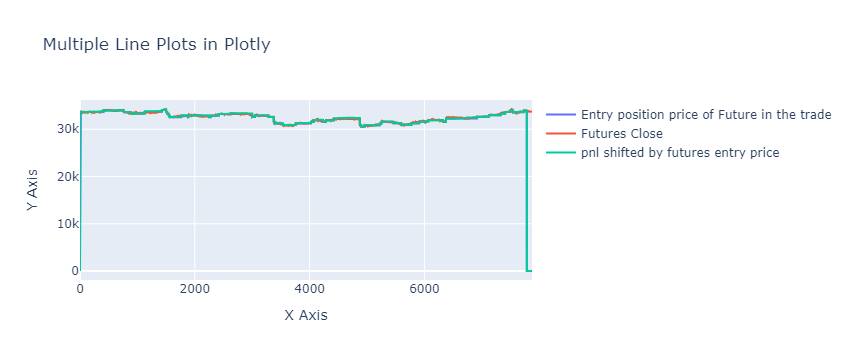

In [1110]:
pd.DataFrame(all_trades, columns=['futures_price', 'pnl_array'])
fig = go.Figure()

# Add first line plot
fig.add_trace(go.Scatter(x=pd.Series(range(len(df_plot))), y=df_plot['futures_price_of_position_at_entry']/100, mode='lines', name='Entry position price of Future in the trade'))

# Add second line plot
fig.add_trace(go.Scatter(x=pd.Series(range(len(df_plot))), y=df_plot['close']/100, mode='lines', name='Futures Close'))

# Add third line plot
fig.add_trace(go.Scatter(x=pd.Series(range(len(df_plot))), y=df_plot['pnl']/100 + df_plot['futures_price_of_position_at_entry']/100, mode='lines', name='pnl shifted by futures entry price'))

# fig.add_trace(go.Scatter(x=pd.Series(range(len(df_plot))), y=df_plot['pnl']/100, mode='lines', name='pnl shifted by futures entry price'))

# Update layout
fig.update_layout(title='Multiple Line Plots in Plotly',
                  xaxis_title='X Axis',
                  yaxis_title='Y Axis')

fig.show()
# Update layout to ensure it uses the full page when displayed
fig.update_layout(
    autosize=True,
    margin=dict(l=0, r=0, t=0, b=0)
)
fig.write_html("graph.html", full_html=True)

In [565]:
def draw_downs(profits):
    dd = 0
    max_dd = 0
    increments = [(profits[i] - profits[i-1]) for i in range(1, len(profits))]
    dds = []
    dd_falls = 0
    falls_peak_height = 0
    peak = 0
    max_dds_peak_height = 0
    max_dds_peak = 0
    max_dds_peak_temp = 0
    max_dds_peak_height_temp = 0
    max_dds_trough_temp = 0
    max_dds_trough_height_temp = 0
    max_dds_trough_depth = 0
    max_dds_peak_till_now = 0
    max_dds_peak_height_till_now = 0
    max_dds_trough_till_now = 0
    max_dds_trough_depth_till_now = 0
    max_dd_till_now = 0
    max_dds_trough = 0
    began = False
    for i, inc in enumerate(increments): 
        # ending of individual drawdowns
        if(inc > 0 and dd_falls != 0):
            dds.append((dd_falls, (peak, falls_peak_height), (i, profits[i])))
            dd_falls = 0
            began = False
        # marking the beginning of the downfall
        if(inc <= 0):
            if began == False:
                peak = i
                falls_peak_height = profits[i]
            began = True
            peak = min(peak, i)
            dd_falls += inc
        # tracking maximum drawdown
        dd += inc
        if(dd > 0):
            dd  = 0
            max_dds_peak_temp = i+1
            max_dds_peak_height_temp = profits[i+1]
        if(max_dd > dd):
            max_dd = dd
            max_dds_trough_temp = i+1
            max_dds_trough_depth_temp = profits[i+1]
        if(max_dd_till_now > max_dd):
            max_dds_peak_till_now = max_dds_peak_temp
            max_dds_peak_height_till_now = max_dds_peak_height_temp
            max_dds_trough_till_now = max_dds_trough_temp
            max_dds_trough_depth_till_now = max_dds_trough_depth_temp
            max_dd_till_now = max_dd 

    max_dd = [max_dd, (max_dds_peak_till_now, max_dds_peak_height_till_now), (max_dds_trough_till_now, max_dds_trough_depth_till_now)]
    return max_dd, dds

In [568]:
_, profits = metrics.PNL()
max_dd, dds = draw_downs(profits)
print(max_dd, dds)

[-264299.22675, (0, 0), (38, -19380.373250000004)] [(-246511.62475000002, (0, 244918.8535), (1, -1592.7712500000198)), (-5964.346749999997, (2, 6425.274750000011), (3, 460.92800000001444)), (-5886.361499999999, (4, 3024.760249999992), (6, -2861.601250000007)), (-9126.214750000014, (7, 2133.6572499999893), (9, -6992.557500000024)), (-7673.403250000003, (10, -640.3822499999951), (11, -8313.785499999998)), (-4754.111499999999, (12, 816.2335000000021), (13, -3937.877999999997)), (-15243.24649999998, (14, -2837.9550000000163), (15, -18081.201499999996)), (-10376.64499999999, (17, 1765.916499999992), (18, -8610.728499999997)), (-9014.413499999966, (19, 1541.8514999999898), (23, -7472.561999999976)), (-1315.5924999999697, (24, -1374.5487500000163), (25, -2690.141249999986)), (-18184.68075, (26, -1194.1782499999972), (27, -19378.858999999997)), (-6986.953249999991, (28, -133.73925000001327), (29, -7120.692500000005)), (-2474.893000000011, (30, -6173.9679999999935), (31, -8648.861000000004)), (

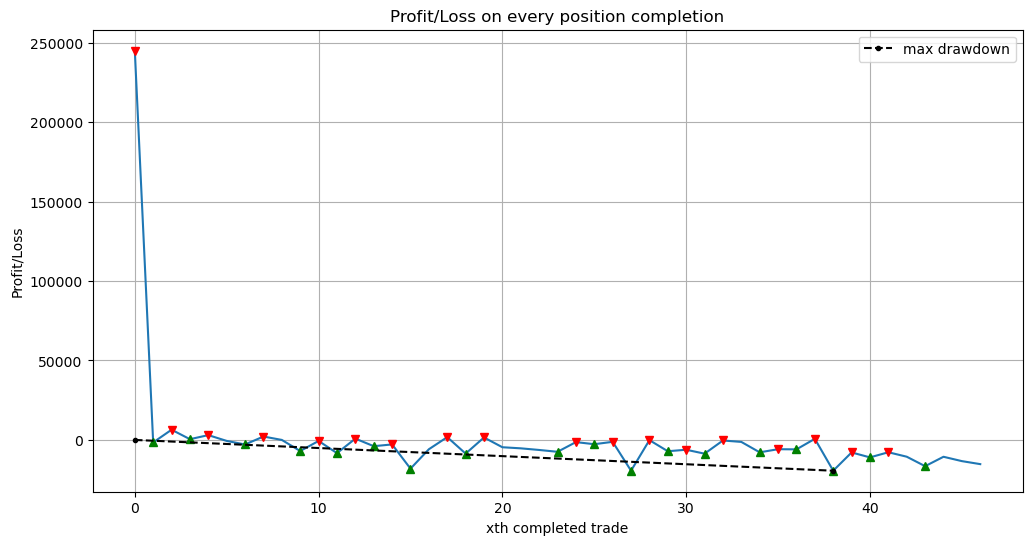

In [569]:
plt.figure(figsize=(12,6))
plt.plot(profits)
for dd in dds:
    plt.plot(dd[1][0], dd[1][1], marker='v', color='r')
    plt.plot(dd[2][0], dd[2][1], marker='^', color='g')
plt.plot([max_dd[1][0], max_dd[2][0]], [max_dd[1][1], max_dd[2][1]], marker = '.', linestyle='--', color='black', label='max drawdown')
plt.grid(True)
plt.title("Profit/Loss on every position completion")
plt.xlabel("xth completed trade")
plt.ylabel("Profit/Loss")
plt.legend()
plt.show()

In [571]:
def plot_futures_and_ema(df, start_date, end_date):
    symbol = df['symbol'].iloc[0]
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    df = df.copy()
    df = df.loc[start:end]
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['close']/100, color='black', label='close price')
    plt.plot(df.index, df['short']/100, color='green', label='short EMA')
    plt.plot(df.index, df['long']/100, color='red', label='long EMA')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.title(f'{symbol} Future Close Prices Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price (in Rs)')
    plt.tight_layout() 
    plt.legend()
    plt.show()

KeyError: 'short'

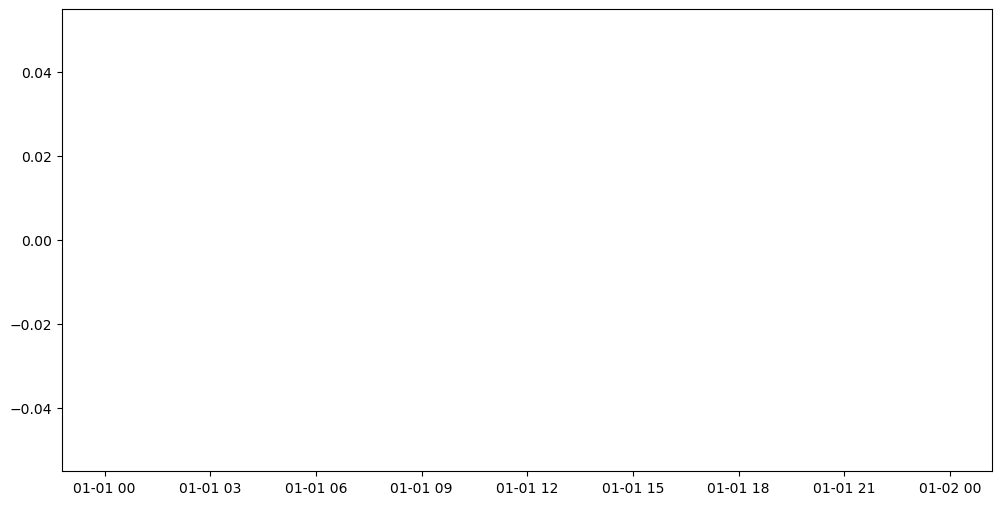

In [572]:
plot_futures_and_ema(df_futures, '2023-12-20', '2023-12-21')

In [ ]:
def plot_options_and_trades(df_options, df_options_in_ram, opt_type, start_date, df_trades, filter_ticks):
    symbol = df_options['symbol'].iloc[0]
    
    start = pd.to_datetime(start_date)
    # end = pd.to_datetime(end_date)
    
    df_lala_options = df_options_in_ram[opt_type].copy()
    # df_lala_options = df_lala_options.loc[start:end]
    df_lala_options = df_lala_options[df_lala_options.index.date == start.date()]

    df_lala_trades = df_trades[df_trades['Call/Put'] == opt_type]
    # df_lala_trades = df_lala_trades.copy().loc[start:end]
    df_lala_trades = df_lala_trades[df_lala_trades.index.date == start.date()]

    strikes_traded = df_lala_trades['strike_price'].unique()
    num_strikes = len(strikes_traded)
    cols = 1
    rows = (num_strikes// cols) + (num_strikes % cols > 0)

    figure, axes = plt.subplots(rows, cols, figsize=(15, 5*rows), squeeze = False)
    axes = axes.flatten()
    
    for i, strike in enumerate(strikes_traded):
        ax = axes[i]
        ax.plot(df_lala_options.index, df_lala_options[strike]/100)
        trade_lines = df_lala_trades['strike_price'] == strike
        trade_lines = df_lala_trades[trade_lines]

        start_loop = int(trade_lines['Position'].iloc[0] == 0)
        for j in range(start_loop, len(trade_lines)-1, 2):
            ax.plot([trade_lines.index[j], trade_lines.index[j+1]], [trade_lines['Price'].iloc[j]/100, trade_lines['Price'].iloc[j+1]/100], color = 'green', marker="o")
            # ax.plot(trade_lines.index[j], trade_lines['Price'].iloc[j]/100, color = 'green', marker="o")
            # ax.plot(trade_lines.index[j+1], trade_lines['Price'].iloc[j+1]/100, color = 'green', marker="o")

        name = "Put"
        if opt_type:
            name = "Call"
        ax.set_title(f"{name} Options price and trades with strike = {strike}")
        ax.set_xlabel("time stamps")
        ax.set_ylabel("close prices in Rs")
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
 
        # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(FuncFormatter(filter_ticks))
   
    for j in range(len(strikes_traded), len(axes)):
        figure.delaxes(axes[j])

    plt.tight_layout() 
    plt.show()

In [ ]:
def filter_ticks(x, pos=None):
    dt = mdates.num2date(x)
    if dt.hour < 9 or (dt.hour == 15 and dt.minute > 29) or dt.hour > 15:
        return ''
    return dt.strftime('%Y-%m-%d %H:%M')

In [ ]:
def plot_all_traded_options(df_options, df_ram, start, df_trades, filter_ticks):
    plot_options_and_trades(df_options, df_ram, 1, start, df_trades, filter_ticks)
    plot_options_and_trades(df_options, df_ram, 0, start, df_trades, filter_ticks)

In [ ]:
plot_all_traded_options(df_options, df_call_put_close, '2023-12-05', df_trades, filter_ticks)